<a href="https://colab.research.google.com/github/isabelklint/final_oa/blob/main/final_oa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
import en_core_web_sm
import gensim
import io
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
import random
import re
import seaborn as sns
import spacy
import string
import warnings
import wordcloud
import seaborn as sns
import math

from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.models import Word2Vec
from google.colab import files
from IPython.core.display import display
from matplotlib import rcParams
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from nltk import ngrams
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# suppress warnings
warnings.filterwarnings("ignore")

# download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# # install required packages
# !pip install spacy
# !pip install gensim
# !pip install pyldavis
# !pip install wordcloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [236]:
# !pip install pyLDAvis

In [237]:
uploaded = files.upload()

Saving open_ave_data.csv to open_ave_data (7).csv


In [238]:
# take a look temp stats
temp = pd.read_csv('open_ave_data.csv', index_col=0)

In [239]:
# remove duplicates
df = temp.drop_duplicates()

In [240]:
df.dropna(inplace=True)

In [241]:
df.describe()

,ReportText,findings,clinicaldata,ExamName,impression
count,950,950,950,950,950
unique,950,406,367,732,486
top,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Chest pain. \n\n,EXAM: CHEST 2 VIEW\n\nCOMPARISON: None.,IMPRESSION: Normal single view chest.
freq,1,174,84,35,160


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 0 to 986
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ReportText    950 non-null    object
 1   findings      950 non-null    object
 2   clinicaldata  950 non-null    object
 3   ExamName      950 non-null    object
 4   impression    950 non-null    object
dtypes: object(5)
memory usage: 44.5+ KB


In [243]:
# make lowercase
df = df.applymap(lambda x: x.lower() if type(x) == str else x)


In [244]:
# remove column name or similar from last four columns:
text_columns = ['findings', 'clinicaldata', 'ExamName', 'impression']
remove_words = ['findings', 'clinical history', 'exam', 'impression']
for col, word in zip(text_columns, remove_words):
    df[col] = df[col].str.replace(word, '', case=False)


In [245]:
# remove stop words, punctuation, and numbers from df
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
text_columns = ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']
for col in text_columns:
    df[col] = df[col].apply(lambda x: ' '.join([word for word in re.findall(r'\b\w+\b', x)
    if word.lower() not in stop_words and not all(char in punctuation or char.isdigit() for char in word)]))

In [246]:
df_original = df

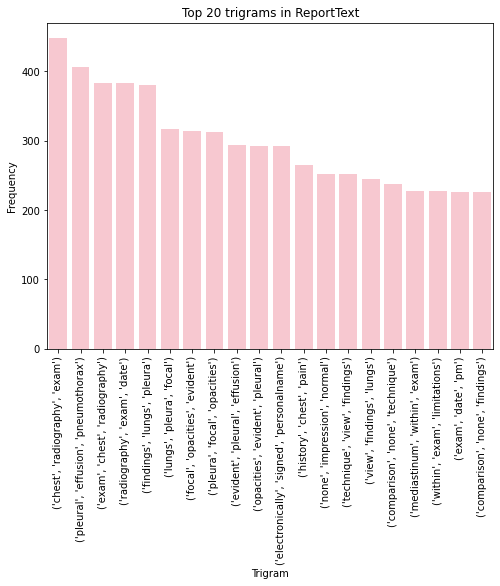

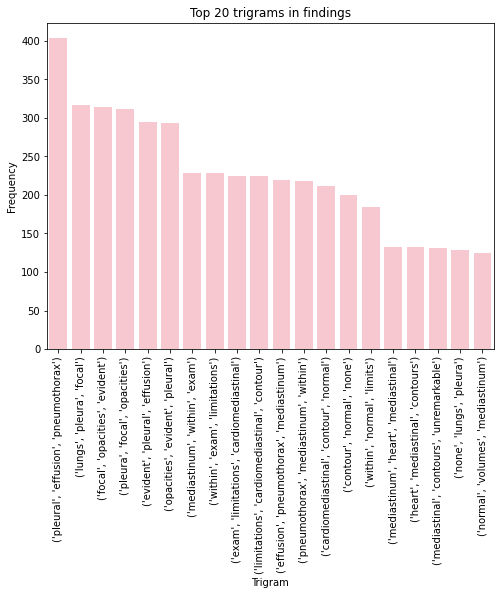

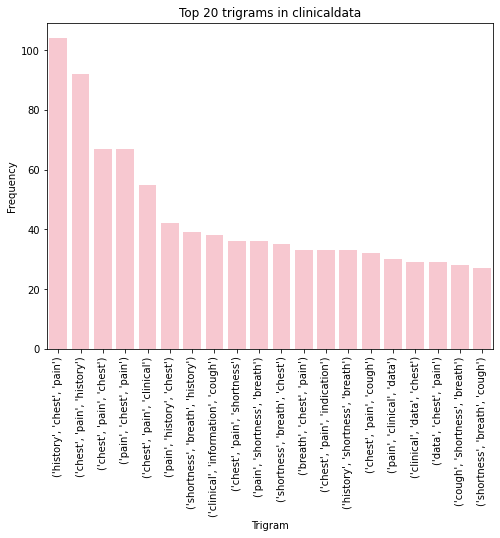

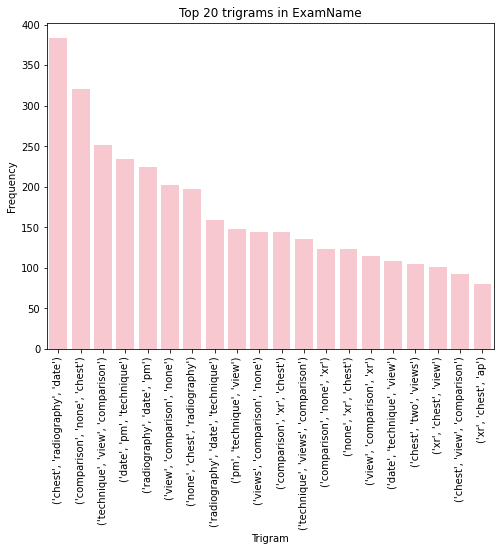

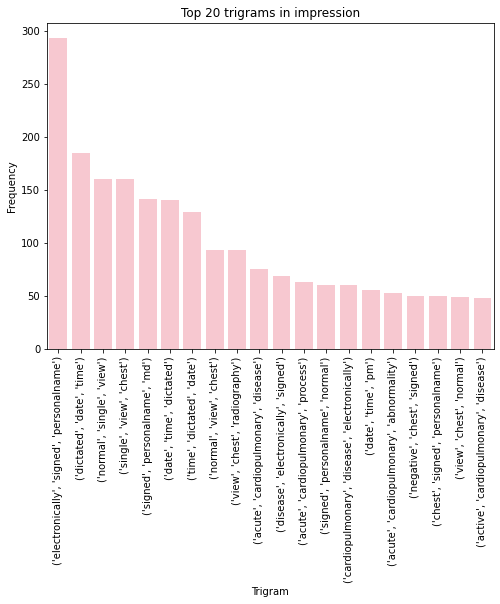

In [247]:
# most frequent tri-grams in text
text_columns = ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']
for col in text_columns:
    data = " ".join(review for review in df[col])
    words = data.split()
    trigrams = ngrams(words, 3)
    ngrams_count = Counter(trigrams)
    top_ngrams = ngrams_count.most_common(20)
    top_ngrams_df = pd.DataFrame(top_ngrams, columns=['n-gram', 'frequency'])
    plt.figure(figsize=(8,6))
    sns.barplot(x='n-gram', y='frequency', data=top_ngrams_df, color='pink')
    plt.title(f'Top 20 trigrams in {col}')
    plt.xlabel('Trigram')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()


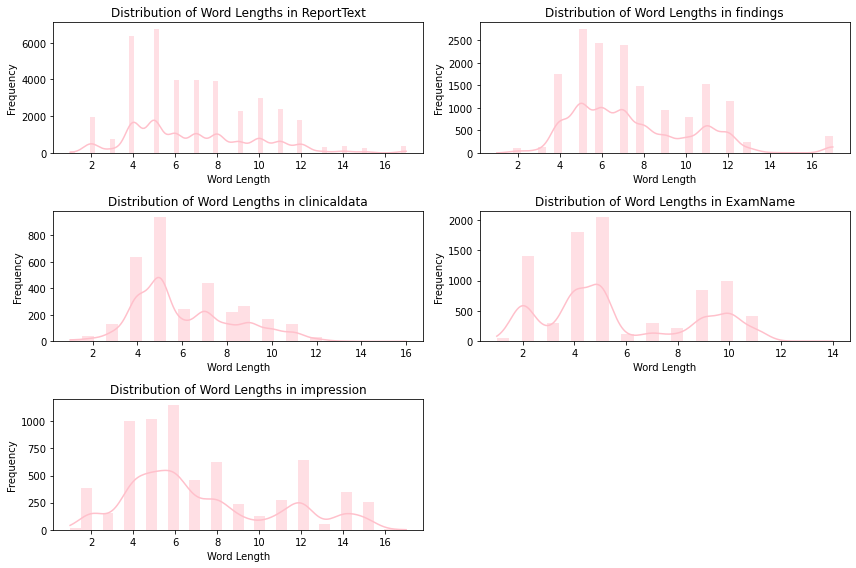

In [248]:
# Text Statistics:  distribution of word lengths
text_columns = ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']
num_cols = 2  # Number of columns in the grid
num_rows = math.ceil(len(text_columns) / num_cols)  # Number of rows in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, col in enumerate(text_columns):
    data = " ".join(review for review in df[col])
    word_lengths = [len(word) for word in data.split()]
    row_idx = i // num_cols  # Row index in the grid
    col_idx = i % num_cols  # Column index in the grid
    ax = axes[row_idx][col_idx] if num_rows > 1 else axes[col_idx]  # Subplot axes
    sns.histplot(word_lengths, kde=True, color='pink', edgecolor='none', ax=ax)
    ax.set_title(f'Distribution of Word Lengths in {col}')
    ax.set_xlabel('Word Length')
    ax.set_ylabel('Frequency')

# Remove any unused subplots
if num_rows * num_cols > len(text_columns):
    for i in range(len(text_columns), num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx][col_idx])

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


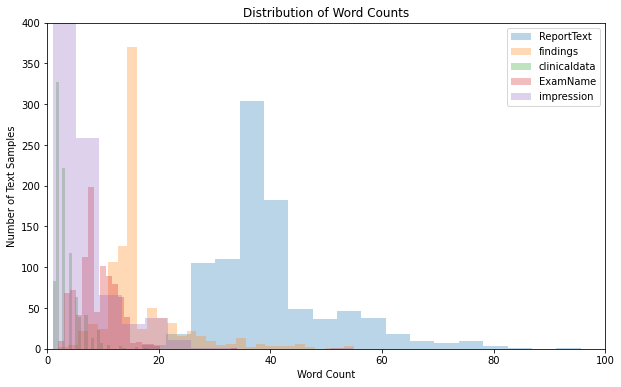

In [249]:
text_columns = ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']

plt.figure(figsize=(10, 6))

for col in text_columns:
    word_counts = df[col].apply(lambda x: len(x.split()))
    count_freq = Counter(word_counts)
    
    plt.hist(word_counts, alpha=0.3, label=col, bins=30)

plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Text Samples')
plt.xlim([0, 100])
plt.ylim([0, 400])
plt.legend()
plt.show()


In [250]:
df.head(2)

,ReportText,findings,clinicaldata,ExamName,impression
0,exam chest radiography exam date pm clinical h...,lungs pleura focal opacities evident pleural e...,cough,chest radiography date pm technique views comp...,normal view chest radiography
1,exam chest radiography exam date pm clinical h...,lungs pleura focal opacities evident pleural e...,chest pain,chest radiography date pm technique view compa...,acute cardiopulmonary abnormality


In [251]:
# !pip install spacy
# !pip install pyLDAvis
# !pip install wordcloud

# import pandas as pd
# import random
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import spacy

spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [252]:
df = temp.applymap(lambda x: x.lower() if type(x) == str else x)


In [253]:

# Define regular expression pattern to remove numbers and punctuation
pattern = r'[^\w\s]|\d+'

# Define function to clean text
def clean_text(text):
    if pd.isna(text):
        return ''
    # Remove newlines
    text = text.replace('\n', ' ')
    # Apply regular expression pattern to remove numbers and punctuation
    text = re.sub(pattern, '', text)
    return text


# Clean the whole DataFrame
df_clean = df.applymap(clean_text)

In [254]:
# load spacy model
nlp = en_core_web_sm.load()

df_clean = df_clean.dropna()
df_clean = df_clean.reset_index(drop=True)

# tokenize text
def tokenize(text):
    lda_tokens = []
    tokens = nlp(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# lemmatize tokens
def get_lemma(token):
    return token.lemma_

def prepare_text_for_lda(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and token.text not in string.punctuation]
    tokens = [token for token in tokens if len(token) > 4 and not token.lower() in ['findings', 'clinical', 'history', 'exam', 'impression']]
    tokens = [get_lemma(nlp(token)[0]) for token in tokens]
    return tokens

# create corpus and dictionary
report_text_data = df_clean['ReportText'].tolist()
text_data = [prepare_text_for_lda(text) for text in report_text_data]
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

# train LDA model (this takes a long time)
NUM_TOPICS = 4
ldamodel = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model4.gensim')

# visualize LDA model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
display(vis)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032482 -0.054651       1        1  34.985061
2     -0.174939  0.143209       2        1  33.872561
0      0.242405  0.072748       3        1  15.970952
1     -0.034984 -0.161307       4        1  15.171426, topic_info=            Term        Freq       Total Category  logprob  loglift
15   radiography  456.000000  456.000000  Default  30.0000  30.0000
82       dictate  263.000000  263.000000  Default  29.0000  29.0000
90      datetime  242.000000  242.000000  Default  28.0000  28.0000
5        evident  307.000000  307.000000  Default  27.0000  27.0000
8    lungspleura  368.000000  368.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
33        breath   37.192151  179.262579   Topic4  -4.6513   0.3130
73     pulmonary   36.086228  237.313105   Topic4  -4.6815   0.0023
4       effusion   42.184686  741.660160   Topic4  -4.5253  -0.9811
13       pleural   36.674514  737.000525   Topic4  -4.6653  -1.1148
14  pneumothorax   36.232906  694.731501   Topic4  -4.6774  -1.0678

[269 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
20        1  0.697125  abnormality
20        2  0.203775  abnormality
20        3  0.050050  abnormality
20        4  0.046475  abnormality
99        1  0.056141       active
...     ...       ...          ...
153       1  0.972612  wellexpande
167       1  0.890249        width
447       2  0.780670        xwise
129       3  0.790272    yesterday
129       4  0.189665    yesterday

[395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

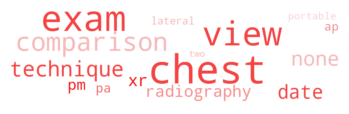

ExamName - Topic 0, Similarity: 0.02, Words: dictate, datetime, chest, stable
ExamName - Topic 1, Similarity: 0.01, Words: chest, normal, electronically, heart
ExamName - Topic 2, Similarity: 0.65, Words: chest, normal, radiography, effusion
ExamName - Topic 3, Similarity: 0.32, Words: chest, acute, normal, comparison


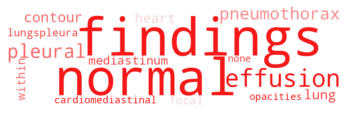

findings - Topic 0, Similarity: 0.16, Words: dictate, datetime, chest, stable
findings - Topic 1, Similarity: 0.15, Words: chest, normal, electronically, heart
findings - Topic 2, Similarity: 0.44, Words: chest, normal, radiography, effusion
findings - Topic 3, Similarity: 0.26, Words: chest, acute, normal, comparison


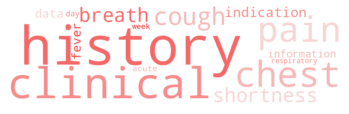

clinicaldata - Topic 0, Similarity: 0.09, Words: dictate, datetime, chest, stable
clinicaldata - Topic 1, Similarity: 0.19, Words: chest, normal, electronically, heart
clinicaldata - Topic 2, Similarity: 0.21, Words: chest, normal, radiography, effusion
clinicaldata - Topic 3, Similarity: 0.51, Words: chest, acute, normal, comparison


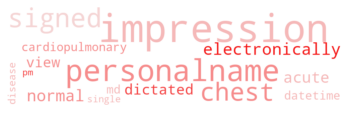

impression - Topic 0, Similarity: 0.27, Words: dictate, datetime, chest, stable
impression - Topic 1, Similarity: 0.22, Words: chest, normal, electronically, heart
impression - Topic 2, Similarity: 0.03, Words: chest, normal, radiography, effusion
impression - Topic 3, Similarity: 0.48, Words: chest, acute, normal, comparison


In [255]:
# make word clouds and compare them to topics: 
# why does this look like 2grams?
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import numpy as np

# create a custom colormap with shades of pink and reds
colors = ["#f5d5d5", "#f5b8b8", "#f68c8c", "#f56868", "#f54242", "#f51818"]
cmap = ListedColormap(colors)

def display_wordcloud(text):
    stopwords = set(STOPWORDS)
    # wc = WordCloud(stopwords=stopwords, background_color='white', width=1000, height=300, colormap=cmap, max_words=10)
    wc = WordCloud(stopwords=stopwords, background_color='white', width=1000, height=300, colormap=cmap, max_words=15, collocations=False)
    wc.generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

for col in ['ExamName', 'findings', 'clinicaldata', 'impression']:
    # text = ' '.join([str(x) + ' ' for x in df_clean[col].fillna('').str.split().tolist()])
    # text = ' '.join([str(x).strip() + ' ' for x in df_clean[col].fillna('').str.split().tolist()])
    text = ' '.join([str(x).replace("'", "") + ' ' for x in df_clean[col].fillna('').str.split().tolist()])
    display_wordcloud(text)
    for i, row in enumerate(ldamodel[dictionary.doc2bow(prepare_text_for_lda(text))]):
        if i >= 10:
            break
        topic_num = row[0]
        topic_words = ldamodel.show_topic(topic_num, 4)
        topic_words = ', '.join([word[0] for word in topic_words])
        similarity = row[1]
        print(f'{col} - Topic {topic_num}, Similarity: {similarity:.2f}, Words: {topic_words}')


In [278]:
data = df_original.drop('ReportText', axis=1)


In [279]:
# Convert all strings to lowercase
data = data.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)


In [280]:
data.head(2)

,findings,clinicaldata,ExamName,impression
0,lungs pleura focal opacities evident pleural e...,cough,chest radiography date pm technique views comp...,normal view chest radiography
1,lungs pleura focal opacities evident pleural e...,chest pain,chest radiography date pm technique view compa...,acute cardiopulmonary abnormality


In [283]:
# Remove 'findings' from the 'findings' column

# # Define unwanted strings
# unwanted_clinicaldata = ['clinical history', 'clinical information', 'history', 'indication', 'indications']

# # Remove unwanted strings from the 'clinicaldata' column
# for string in unwanted_clinicaldata:
#     df['clinicaldata'] = df['clinicaldata'].str.replace(string, '').str.strip()

# Print the modified DataFrame
print(data.head())

                                            findings  \
0  lungs pleura focal opacities evident pleural e...   
1  lungs pleura focal opacities evident pleural e...   
2  lungs pleura focal opacities evident pleural e...   
3              heart size appears normal lungs clear   
4  lungs pleura focal opacities evident pleural e...   

                  clinicaldata  \
0                        cough   
1                   chest pain   
2                   chest pain   
3           history chest pain   
4  chest pain shortness breath   

                                            ExamName  \
0  chest radiography date pm technique views comp...   
1  chest radiography date pm technique view compa...   
2  chest radiography date pm technique views comp...   
3                     chest portable comparison none   
4  chest radiography date pm technique view compa...   

                          impression  
0      normal view chest radiography  
1  acute cardiopulmonary abnormality  
2   

In [284]:
# melt dataframe
df_melted = pd.melt(data, var_name='label', value_name='text')
# display melted dataframe
print(df_melted)

           label                                               text
0       findings  lungs pleura focal opacities evident pleural e...
1       findings  lungs pleura focal opacities evident pleural e...
2       findings  lungs pleura focal opacities evident pleural e...
3       findings              heart size appears normal lungs clear
4       findings  lungs pleura focal opacities evident pleural e...
...          ...                                                ...
3795  impression                            acute pulmonary disease
3796  impression  evidence acute intrathoracic disease electroni...
3797  impression                           normal single view chest
3798  impression  acute cardiopulmonary process dictated persona...
3799  impression  persistent mild pulmonary vascular congestion ...

[3800 rows x 2 columns]


In [285]:
df = df.dropna(subset=['text'])


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4766 samples in 0.002s...
[t-SNE] Computed neighbors for 4766 samples in 0.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4766
[t-SNE] Computed conditional probabilities for sample 2000 / 4766
[t-SNE] Computed conditional probabilities for sample 3000 / 4766
[t-SNE] Computed conditional probabilities for sample 4000 / 4766
[t-SNE] Computed conditional probabilities for sample 4766 / 4766
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.401329
[t-SNE] KL divergence after 300 iterations: 1.615021


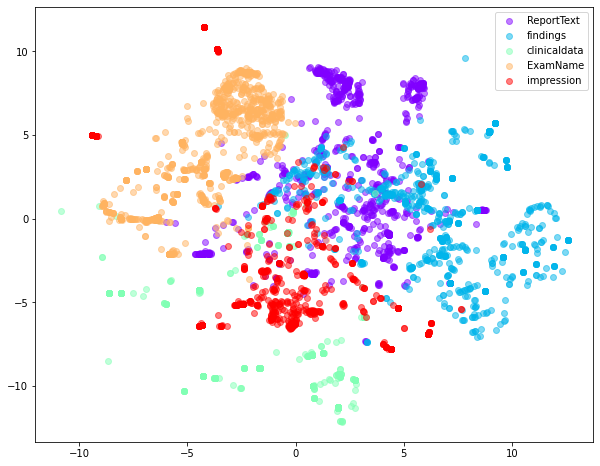

In [286]:
# create a list of unique labels
labels = df['label'].unique()

# generate tf-idf embeddings
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['text'])

# apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# create a scatter plot with color coded sections
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    color = plt.cm.rainbow(np.linspace(0, 1, len(labels)))[i]
    indices = df['label'] == label
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=color, label=label, alpha=0.5)
plt.legend()
plt.show()


In [287]:
# Load the data into a DataFrame
data = df

# Split the data into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(train_data['text'])

# Transform the text data into a numerical feature matrix
train_features = vectorizer.transform(train_data['text'])
test_features = vectorizer.transform(test_data['text'])

# Create the logistic regression classifier
classifier = LogisticRegression(C=1, solver='saga')

# Train the classifier on the training data
classifier.fit(train_features, train_data['label'])

# Predict labels for the testing data
predictions = classifier.predict(test_features)

# Print the accuracy score
accuracy = accuracy_score(test_data['label'], predictions)
print("Accuracy:", accuracy)

# Print the confusion matrix
cm = confusion_matrix(test_data['label'], predictions)
print("Confusion Matrix:\n", cm)

# Print the classification report
cr = classification_report(test_data['label'], predictions)
print("Classification Report:\n", cr)


Accuracy: 0.989517819706499
Confusion Matrix:
 [[186   0   0   0   0]
 [  0 206   0   1   3]
 [  0   0 178   0   0]
 [  0   0   1 185   1]
 [  0   0   1   3 189]]
Classification Report:
               precision    recall  f1-score   support

    ExamName       1.00      1.00      1.00       186
  ReportText       1.00      0.98      0.99       210
clinicaldata       0.99      1.00      0.99       178
    findings       0.98      0.99      0.98       187
  impression       0.98      0.98      0.98       193

    accuracy                           0.99       954
   macro avg       0.99      0.99      0.99       954
weighted avg       0.99      0.99      0.99       954



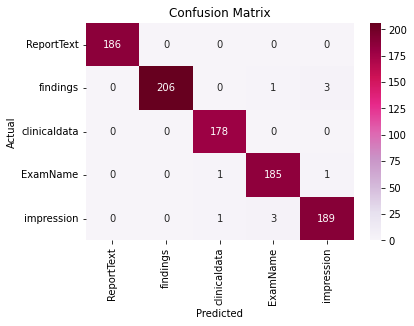

In [288]:
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set the x-axis labels
plt.xticks([0.5, 1.5, 2.5, 3.5], ['findings', 'clinicaldata', 'ExamName', 'impression'])

# Set the y-axis labels
plt.yticks([0.5, 1.5, 2.5, 3.5], ['findings', 'clinicaldata', 'ExamName', 'impression'])

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()



In [289]:
df_melted.head(2)

,label,text
0,findings,lungs pleura focal opacities evident pleural e...
1,findings,lungs pleura focal opacities evident pleural e...


In [301]:
import nltk
nltk.download('punkt')

# Tokenize the text in df_melted
df_melted['tokenized_text'] = df_melted['text'].apply(nltk.word_tokenize)

# Extract the embeddings
embeddings = []
out_of_vocab = []
for word_list in df_melted['tokenized_text'].values:
    for word in word_list:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            out_of_vocab.append(word)
            
if len(out_of_vocab) > 0:
    print(f"Ignoring {len(out_of_vocab)} out-of-vocabulary words: {', '.join(out_of_vocab)}")
    
embeddings = np.array(embeddings)
# clearly when i deleted 'exam' it left 'examination' go back and fix this

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ignoring 26 out-of-vocabulary words: ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, inations, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination, ination


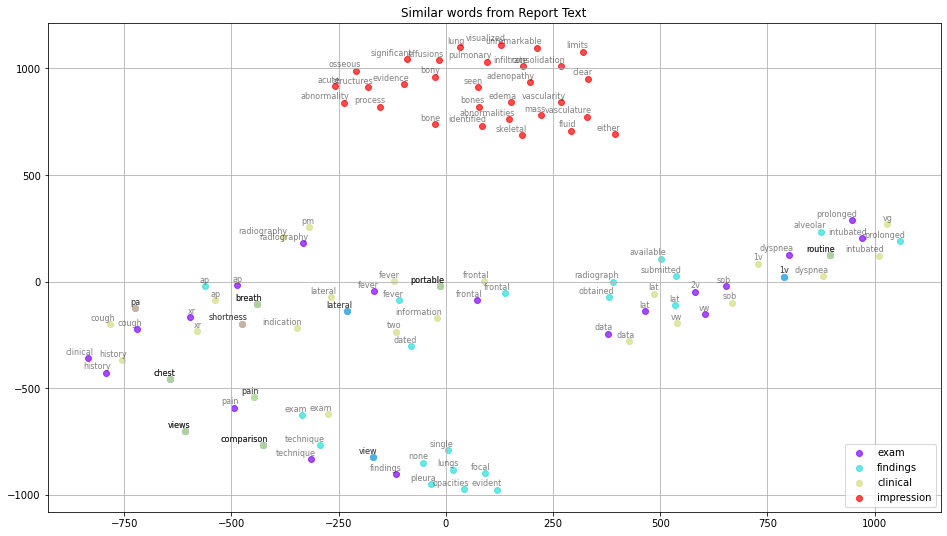

In [302]:
keys = ['exam', 'findings', 'clinical', 'impression']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=np.array([color]), alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Report Text', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')


In [ ]:
# from gensim.models import Word2Vec
# from nltk.corpus import stopwords
# from sklearn.manifold import TSNE
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm

# # Load stop words
# stop_words = stopwords.words('english')

# # Load word2vec model
# model = Word2Vec(df_original['ReportText'], vector_size=300, window=5, min_count=1, workers=4)

# # Create sentence embeddings
# sentence_embeddings = []
# for sentence in df_melted['text']:
#     words = sentence.split()
#     words = [word for word in words if word not in stop_words]
#     word_embeddings = []
#     for word in words:
#         if word in model.wv.key_to_index:
#             word_embeddings.append(model.wv[word])
#     if word_embeddings:
#         sentence_embedding = np.mean(word_embeddings, axis=0)
#         sentence_embeddings.append(sentence_embedding)

# # Stack sentence embeddings into 2D array
# sentence_embeddings = np.vstack(sentence_embeddings)

# # Apply t-SNE to sentence embeddings
# tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
# embeddings_en_2d = tsne_model_en_2d.fit_transform(sentence_embeddings)

# # Plot sentence embeddings
# plt.figure(figsize=(16, 9))
# plt.scatter(embeddings_en_2d[:, 0], embeddings_en_2d[:, 1])
# plt.title('Sentence Embeddings')
# plt.show()


In [ ]:
# from gensim.models import Word2Vec
# from nltk.corpus import stopwords
# from sklearn.manifold import TSNE
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm

# # Load stop words
# stop_words = stopwords.words('english')

# # Load word2vec model
# model = Word2Vec(df_original['ReportText'], vector_size=300, window=5, min_count=1, workers=4)

# # Create sentence embeddings
# sentence_embeddings = []
# labels = []
# for idx, row in df_melted.iterrows():
#     sentence = row['text']
#     label = row['label']
#     words = sentence.split()
#     words = [word for word in words if word not in stop_words]
#     word_embeddings = []
#     for word in words:
#         if word in model.wv.key_to_index:
#             word_embeddings.append(model.wv[word])
#     if word_embeddings:
#         sentence_embedding = np.mean(word_embeddings, axis=0)
#         sentence_embeddings.append(sentence_embedding)
#         labels.append(label)

# # Stack sentence embeddings into 2D array
# sentence_embeddings = np.vstack(sentence_embeddings)

# # Apply t-SNE to sentence embeddings
# tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
# embeddings_en_2d = tsne_model_en_2d.fit_transform(sentence_embeddings)

# # Plot sentence embeddings
# plt.figure(figsize=(16, 9))
# colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
# for label, color in zip(set(labels), colors):
#     idxs = np.where(np.array(labels) == label)[0]
#     plt.scatter(embeddings_en_2d[idxs, 0], embeddings_en_2d[idxs, 1], color=color, label=label, alpha=0.7)
# plt.legend(loc='best')
# plt.title('Sentence Embeddings')
# plt.show()


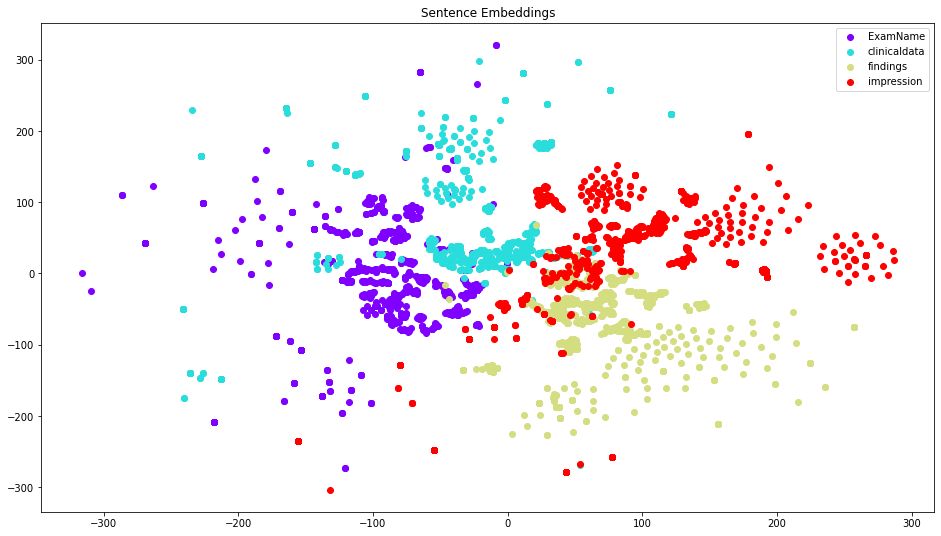

In [335]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load stop words
stop_words = stopwords.words('english')

# Tokenize sentences into lists of words
sentences = [s.split() for s in df_original['ReportText']]

# Load word2vec model
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Create sentence embeddings
sentence_embeddings = []
labels = df_melted['label']
for sentence, label in zip(df_melted['text'], labels):
    words = sentence.split()
    words = [word for word in words if word not in stop_words]
    word_embeddings = []
    for word in words:
        if word in model.wv.key_to_index:
            word_embeddings.append(model.wv[word])
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Stack sentence embeddings into 2D array
sentence_embeddings = np.vstack(sentence_embeddings)

# Apply t-SNE to sentence embeddings
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = tsne_model_en_2d.fit_transform(sentence_embeddings)

# Plot sentence embeddings
plt.figure(figsize=(16, 9))
labels = np.unique(df_melted['label'])
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
for label, color in zip(labels, colors):
    indices = np.where(df_melted['label'] == label)
    plt.scatter(embeddings_en_2d[indices, 0], embeddings_en_2d[indices, 1], c=color, label=label)
plt.title('Sentence Embeddings')
plt.legend()
plt.show()


In [336]:
def tsne_plot_similar_sentences(title, labels, sentence_embeddings, sentence_labels, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embedding, sentence_label, color in zip(labels, sentence_embeddings, sentence_labels, colors):
        x = embedding[0]
        y = embedding[1]
        plt.scatter(x, y, c=np.array([color]), alpha=a, label=label)
        plt.annotate(sentence_label, alpha=0.5, xy=(x, y), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


In [ ]:
# # Create a TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer()

# # Compute the TF-IDF vectors
# tfidf_vectors = tfidf_vectorizer.fit_transform(df_cleaned['text'])

# # Create a 2D visualization of different fields using TF-IDF vectors
# svd = TruncatedSVD(n_components=2, random_state=42)
# tfidf_vectors_2d = svd.fit_transform(tfidf_vectors)
# sns.scatterplot(x=tfidf_vectors_2d[:, 0], y=tfidf_vectors_2d[:, 1], hue=df_cleaned['label'])
# plt.title('2D Visualization of Different Fields using TF-IDF Vectors')
# plt.show()

# # Train a logistic regression model with Word2Vec vectors
# X = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in sentences])
# y = df_cleaned['label']
# lr_w2v = LogisticRegression(random_state=42)
# lr_w2v.fit(X, y)

# # Train a logistic regression model with TF-IDF vectors
# lr_tfidf = LogisticRegression(random_state=42)
# lr_tfidf.fit(tfidf_vectors, y)

# # Compute the accuracies of both models on the training set
# X_test = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in sentences])
# tfidf_vectors_test = tfidf_vectorizer.transform(df_cleaned['text'])
# y_pred_w2v = lr_w2v.predict(X_test)
# y_pred_tfidf = lr_tfidf.predict(tfidf_vectors_test)
# accuracy_w2v = accuracy_score(y, y_pred_w2v)
# accuracy_tfidf = accuracy_score(y, y_pred_tfidf)

# # Print the accuracies of both models
# print('Accuracy using Word2Vec vectors: {:.2f}'.format(accuracy_w2v))
# print('Accuracy using TF-IDF vectors: {:.2f}'.format(accuracy_tfidf))


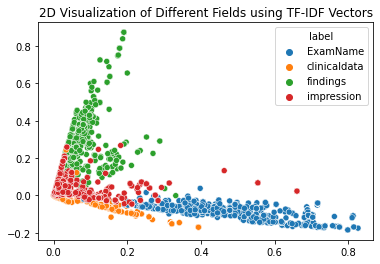

Accuracy using Word2Vec vectors: 0.93
Accuracy using TF-IDF vectors: 0.99


In [340]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df_melted['text'])

# Create a 2D visualization of different fields using TF-IDF vectors
svd = TruncatedSVD(n_components=2, random_state=42)
tfidf_vectors_2d = svd.fit_transform(tfidf_vectors)
sns.scatterplot(x=tfidf_vectors_2d[:, 0], y=tfidf_vectors_2d[:, 1], hue=df_melted['label'])
plt.title('2D Visualization of Different Fields using TF-IDF Vectors')
plt.show()

# Train a logistic regression model with Word2Vec vectors
sentences = [s.split() for s in df_melted['text']]
X = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
y = df_melted['label']
lr_w2v = LogisticRegression(random_state=42)
lr_w2v.fit(X, y)

# Train a logistic regression model with TF-IDF vectors
lr_tfidf = LogisticRegression(random_state=42)
lr_tfidf.fit(tfidf_vectors, y)

# Compute the accuracies of both models on the training set
X_test = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
tfidf_vectors_test = tfidf_vectorizer.transform(df_melted['text'])
y_pred_w2v = lr_w2v.predict(X_test)
y_pred_tfidf = lr_tfidf.predict(tfidf_vectors_test)
accuracy_w2v = accuracy_score(y, y_pred_w2v)
accuracy_tfidf = accuracy_score(y, y_pred_tfidf)

# Print the accuracies of both models
print('Accuracy using Word2Vec vectors: {:.2f}'.format(accuracy_w2v))
print('Accuracy using TF-IDF vectors: {:.2f}'.format(accuracy_tfidf))


In [341]:
from sklearn.metrics import classification_report

# Generate classification report for Word2Vec model
print('Classification report for Word2Vec model:')
print(classification_report(y, y_pred_w2v))

# Generate classification report for TF-IDF model
print('Classification report for TF-IDF model:')
print(classification_report(y, y_pred_tfidf))


Classification report for Word2Vec model:
              precision    recall  f1-score   support

    ExamName       0.99      0.88      0.93       950
clinicaldata       0.88      0.96      0.92       950
    findings       0.92      0.95      0.93       950
  impression       0.93      0.92      0.92       950

    accuracy                           0.93      3800
   macro avg       0.93      0.93      0.93      3800
weighted avg       0.93      0.93      0.93      3800

Classification report for TF-IDF model:
              precision    recall  f1-score   support

    ExamName       1.00      1.00      1.00       950
clinicaldata       1.00      1.00      1.00       950
    findings       0.99      0.99      0.99       950
  impression       1.00      0.99      0.99       950

    accuracy                           0.99      3800
   macro avg       0.99      0.99      0.99      3800
weighted avg       0.99      0.99      0.99      3800

